## Covid-19 Data
Data obtained from the New York Times: 

https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv  
https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [8]:
import io
import pandas as pd
import numpy as np
import scipy as sp
import requests
import re
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import rgb2hex, Normalize, LogNorm
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
import os
import conda

%matplotlib inline

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [12]:
cdata, sdata, slatest, data_asof = get_data()

### Total Reported US Cases

In [13]:
national = sdata.groupby(['date'])[['cases', 'deaths']].sum()
national.index.name = None
national['CFR'] = round(national['deaths'] / national['cases'], 3)
print(national.sort_index(ascending=False).head(n=7))

             cases  deaths    CFR
2020-04-07  397754   12956  0.033
2020-04-06  366238   10959  0.030
2020-04-05  336774    9655  0.029
2020-04-04  311536    8499  0.027
2020-04-03  276501    7121  0.026
2020-04-02  244423    6232  0.025
2020-04-01  214711    4841  0.023


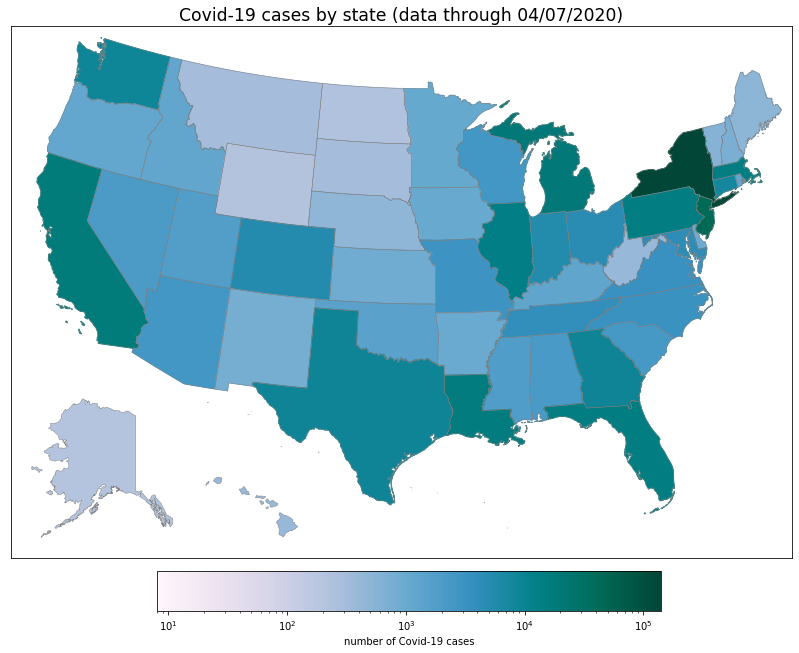

In [25]:
plot_cases_map(slatest)

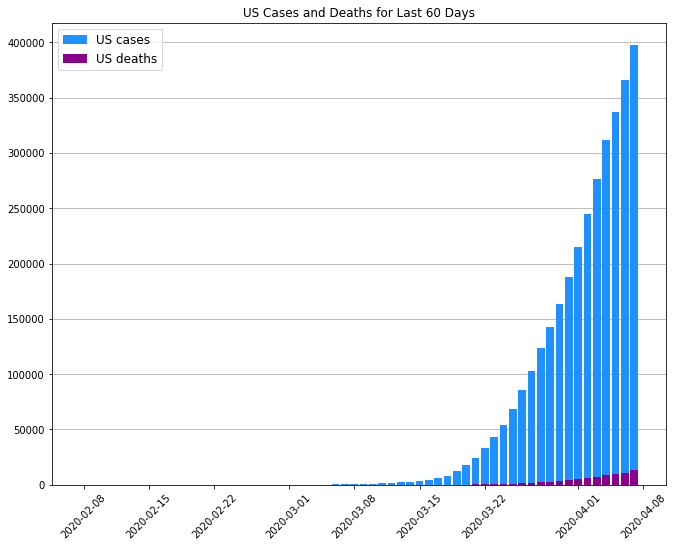

In [26]:
plot_us_cases(60)

### Case Fatality Ratio

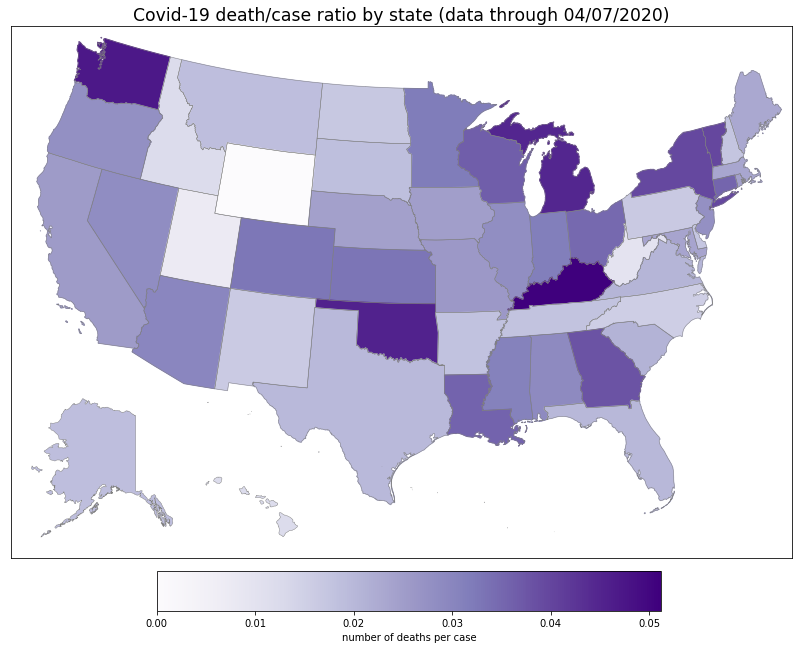

In [28]:
plot_cfr_map(slatest)

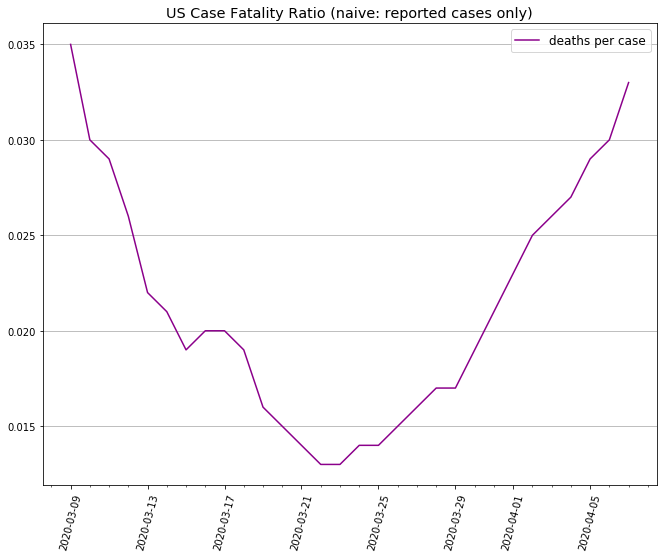

In [27]:
plot_cfr()

### County + State Data 

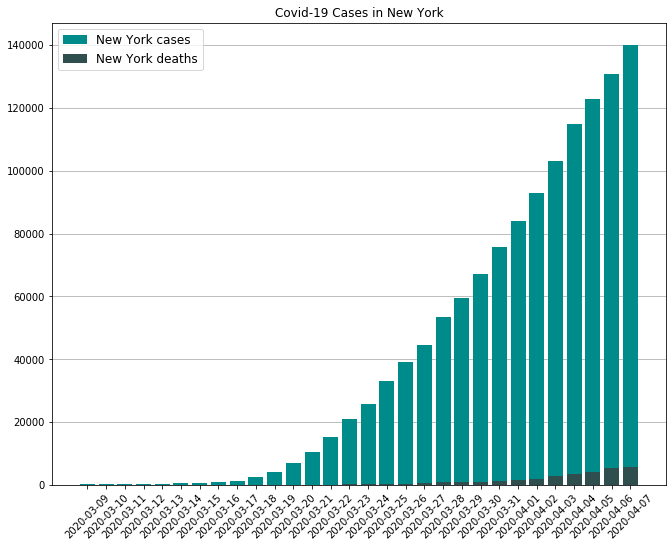

In [31]:
plot_state("New York")

Leon County
2020-04-07: 67 cases, 0 deaths


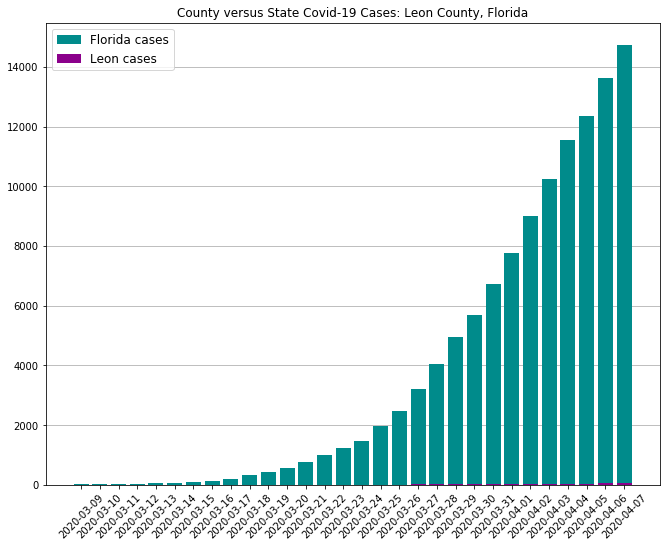

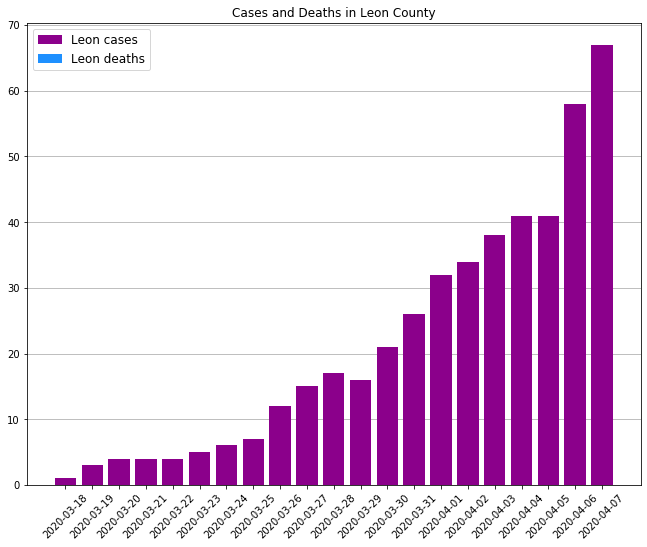

In [32]:
plot_county("Florida", "Leon")

#### FUNCTIONS

In [15]:
def get_data():
    url_counties = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
    url_states = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
    cdata = pd.read_csv(url_counties)
    sdata = pd.read_csv(url_states)
    sdata['date'] = pd.to_datetime(sdata['date'])
    slatest = sdata[sdata.groupby('state').date.transform('max') == sdata['date']]
    data_asof = slatest.date.tolist()[0]
    return cdata, sdata, slatest, data_asof

In [16]:
def plot_us_cases(days=30):
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.bar(national.index[-days:], national.iloc[-days:]['cases'], label="US cases", color='dodgerblue')
    ax.bar(national.index[-days:], national.iloc[-days:]['deaths'], label="US deaths", color='darkmagenta')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, fontsize='medium')
    plt.title("US Cases and Deaths for Last %d Days" % days)
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

In [30]:
def plot_state(state_name, days=30, labels=False):

    dfstate = cdata[cdata.state == state_name].groupby(['date'])[['cases', 'deaths']].sum()
    dfstate.sort_values(by='date', ascending=True, inplace=True)
    
    latest = dfstate.iloc[-1]
    title = "Covid-19 Cases in {}".format(state_name)

    # plot state cases vs county cases
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.bar(dfstate.index.tolist()[-days:], 
           dfstate.iloc[-days:]['cases'], 
           label="%s cases" % state_name, 
           color='darkcyan')
    if labels:
        add_value_labels(ax, 3)
    ax.bar(dfstate.index.tolist()[-days:],
           dfstate.iloc[-days:]['deaths'],
           label="%s deaths" % state_name,
           color='darkslategrey')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.title(title)
    plt.xticks(rotation=45, fontsize='medium')
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

In [18]:
def plot_county(state_name, county_name, days=30, labels=False):
    dfcounties = cdata[cdata['state'] == state_name]
    dfstate = dfcounties.groupby(['date'])[['cases', 'deaths']].sum()
    if county_name in dfcounties['county'].tolist():
        coflag = 1
        dfco = dfcounties[dfcounties['county'] == county_name]
        latest = dfco.iloc[-1].tolist()
        print(latest[1], "County")
        print("{}: {} cases, {} deaths".format(latest[0], latest[4], latest[5]))
        title = "County versus State Covid-19 Cases: {} County, {}".format(county_name, state_name)
    else: 
        print("County '{}' not found in state '{}'.".format(county_name, state_name))
        return
    
    # plot state cases vs county cases
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.bar(dfstate.index.tolist()[-days:], 
           dfstate.iloc[-days:]['cases'], 
           label="%s cases" % state_name, 
           color='darkcyan')
    if labels:
        add_value_labels(ax, 3)
    if coflag:
        ax.bar(dfco[dfco['county'] == county_name].iloc[-days:]['date'], 
               dfco[dfco['county'] == county_name].iloc[-days:]['cases'], 
               label='%s cases' % county_name, 
               color='darkmagenta')
    else:
        ax.bar(dfstate.index.tolist()[-days:],
               dfstate.iloc[-days:]['deaths'],
               label="%s deaths" % state_name,
               color='darkslategrey')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.title(title)
    plt.xticks(rotation=45, fontsize='medium')
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

    # plot county cases vs deaths

    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(11, 8.5)
    ax1.bar(dfco[dfco['county'] == county_name]['date'], 
           dfco[dfco['county'] == county_name]['cases'], 
           label='%s cases' % county_name, 
           color='darkmagenta')
    ax1.bar(dfco[dfco['county'] == county_name]['date'], 
           dfco[dfco['county'] == county_name]['deaths'], 
           label='%s deaths' % county_name, 
           color='dodgerblue')
    ax1.grid(axis='y')
    ax1.set_axisbelow(True)
    plt.title("Cases and Deaths in {} County".format(county_name))
    plt.xticks(rotation=45, fontsize='medium')
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

In [19]:
def add_value_labels(ax, spacing=5):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{:.0f}".format(y_value)

        ax.annotate(
            label,                      
            (x_value, y_value),        
            xytext=(0, space),         
            textcoords="offset points", 
            ha='center', va=va)                      

In [20]:
def get_new_deaths(state, county=None):
    if county is not None and county in cdata['county'].unique().tolist():
        df = cdata[(cdata.state == state) & (cdata.county == county)]
        df.sort_values(by='date', inplace=True, ascending=True)
        return df.deaths.iloc[-1] - df.deaths.iloc[-2]
    else:
        if county is not None:
            print("County \"{}\" not found in state \"{}\"".format(county, state))
            print("New deaths for {}:".format(state))
        df = sdata[sdata['state'] == state]
        return df.deaths.iloc[-1] - df.deaths.iloc[-2]

In [21]:
def plot_cfr(days=30):
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.plot(national.index[-days:], national.iloc[-days:]['CFR'], label='deaths per case', color='darkmagenta')
    plt.title("US Case Fatality Ratio (naive: reported cases only)", fontsize='x-large')
    plt.xticks(rotation=75)
    plt.legend(loc=1, fancybox=True, fontsize='large')
    ax.grid(axis='y')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_axisbelow(True)
    plt.show()

In [22]:
def plot_cfr_map(slatest):
    warnings.simplefilter('ignore') 
    slatest = slatest[slatest['state'] != 'Northern Mariana Islands']
    slatest['CFR'] = slatest.deaths / slatest.cases
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 11)
    plt.title("Covid-19 death/case ratio by state (data through {})".format(
        data_asof.strftime("%m/%d/%Y")) , fontsize='xx-large')

    # basemap: contiguous
    m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # basemap: non-continguous
    m_ = Basemap(llcrnrlon=-190, llcrnrlat=20, urcrnrlon=-143, urcrnrlat=46, 
                projection='merc', lat_ts=20)

    # state boundaries from US Census Bureau
    ## http://www.census.gov/geo/www/cob/st2000.html
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                               linewidth=0.45,color='gray')
    shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

    colors={}
    statenames=[]
    cmap = plt.cm.Purples 
    vmin = np.min(slatest[slatest['date'] == data_asof]['CFR'])
    vmax = np.max(slatest[slatest['date'] == data_asof]['CFR'])
    norm = Normalize(vmin=vmin, vmax=vmax) 
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    nodatacolor = 'lightgrey'
    nodatalegend = None

    # get data from df, put in color list
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        # skip DC and Puerto Rico.
        if statename not in ['District of Columbia','Puerto Rico']:
            if statename not in slatest['state'].unique().tolist():
                colors[statename] = nodatacolor
            ratio = slatest[slatest['state'] == statename]['CFR']
            colors[statename] = mapper.to_rgba(ratio)
        statenames.append(statename)

    # color the states
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            if (colors[statenames[nshape]] == nodatacolor):
                nodatalegend = poly
            ax.add_patch(poly)

    # adjust position/size of non-contiguous states to plot as insets
    THRESHOLD1 = 0.005              # exclude threshold for Hawaii
    THRESHOLD2 = THRESHOLD1 * 30.0  # exclude threshold for Alaska
    AK_SCALE = 0.2                  # scale down Alaska to show as a map inset
    HI_OFFSET_X = -1900000          # put AK and HI in main view
    HI_OFFSET_Y = 250000    
    AK_OFFSET_X = -250000   
    AK_OFFSET_Y = -750000   

    for nshape, shapedict in enumerate(m_.states_info):  
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > THRESHOLD1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > THRESHOLD2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y * AK_SCALE + AK_OFFSET_Y)\
                       for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
            ax.add_patch(poly)

    # if any states with no data, add legend
    if nodatalegend is not None:
        plt.legend((nodatalegend,), ('no reported cases',))

    # colorbar
    cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel('number of deaths per case')

    plt.show()

In [23]:
def plot_cases_map(slatest):
    warnings.simplefilter('ignore') 
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 11)
    plt.title("Covid-19 cases by state (data through {})".format(
        data_asof.strftime("%m/%d/%Y")) , fontsize='xx-large')

    # basemap: contiguous
    m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # basemap: non-continguous
    m_ = Basemap(llcrnrlon=-190, llcrnrlat=20, urcrnrlon=-143, urcrnrlat=46, 
                projection='merc', lat_ts=20)

    # state boundaries from US Census Bureau
    ## http://www.census.gov/geo/www/cob/st2000.html
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                               linewidth=0.45,color='gray')
    shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

    colors={}
    statenames=[]
    cmap = plt.cm.PuBuGn 
    vmin = min(slatest.cases); vmax = max(slatest.cases) 
    norm = LogNorm(vmin=vmin, vmax=vmax) 
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    nodatacolor = 'lightgrey'
    nodatalegend = None

    # get data from df, put in color list
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        # skip DC and Puerto Rico.
        if statename not in ['District of Columbia','Puerto Rico']:
            if statename not in slatest['state'].unique().tolist():
                colors[statename] = nodatacolor
            cases = slatest[slatest['state'] == statename]['cases']
            colors[statename] = mapper.to_rgba(cases)
        statenames.append(statename)

    # color the states
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            if (colors[statenames[nshape]] == nodatacolor):
                nodatalegend = poly
            ax.add_patch(poly)

    # adjust position/size of non-contiguous states to plot as insets
    THRESHOLD1 = 0.005              # exclude threshold for Hawaii
    THRESHOLD2 = THRESHOLD1 * 30.0  # exclude threshold for Alaska
    AK_SCALE = 0.2                  # scale down Alaska to show as a map inset
    HI_OFFSET_X = -1900000          # put AK and HI in main view
    HI_OFFSET_Y = 250000    
    AK_OFFSET_X = -250000   
    AK_OFFSET_Y = -750000   

    for nshape, shapedict in enumerate(m_.states_info):  
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > THRESHOLD1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > THRESHOLD2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y * AK_SCALE + AK_OFFSET_Y)\
                       for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
            ax.add_patch(poly)

    # if any states with no data, add legend
    if nodatalegend is not None:
        plt.legend((nodatalegend,), ('no reported cases',))

    # colorbar
    cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel('number of Covid-19 cases')

    plt.show()


In [24]:
def plot_top_state_growth(days=30):
    plot_states = sdata[sdata['date'] == data_asof].sort_values('cases', ascending=False).iloc[:10]['state'].tolist()
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for st in plot_states:
        x = sdata[sdata['state'] == st].sort_values('date', ascending=True).iloc[-days:]['date']
        y = sdata[sdata['state'] == st].sort_values('date', ascending=True).iloc[-days:]['cases']
        ax.plot(x, y, label='%s cases' % st, color=colors[plot_states.index(st)])

    plt.legend(loc=2, fancybox=True)
    plt.title("US states with most cases")
    plt.xticks(rotation=70)
    plt.show()